### Calculation of pixel-wise correlation between $\delta\gamma_{0}$ and net water accumulation
- Uses the net water daily and ALOS-2 PALSAR-2 outputs from Process_ALOS_areas.ipynb
- previous code: PW_corr_quickstart.ipynb
- Quickstart option below for opening the nw_accums file (this takes a while to create)

Inputs:
- HH_db_100m_area2.nc + HV/RVI/HHHV + areas 1 to 5 with similar file naming formats.
- nw_daily_new_100m.nc (net water on same grid as HH data for comparison)

Outputs:
- pixel wise correlations between $\delta$NW and $\delta\sigma_0$ 

In [1]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Declare data and output directories

env: HDF5_USE_FILE_LOCKING=FALSE


### Functions

In [2]:
# new pixel wise correlation function
# uses x-array in-built correlation and covariance functions

def pw_correlations(x,y):
    # inputs: two x-arrays
    # calculates correlation, covaraiance, mean and standard deviation pixel values across the time series
    # also slope and p-values
    
    # the number of timesteps
    n = y.notnull().sum(dim='time')
    print ("timesteps: " + str(n))
    
    # calculating the mean and standard deviations across all time steps
    x_mean = x.mean(axis=0)
    y_mean = y.mean(axis=0)
    x_std  = x.std(axis=0)
    y_std  = y.std(axis=0)
    
    # covariance
    cov = xr.cov(x,y)
    
    # correlation
    cor = xr.corr(x,y)
    
    # slope and intercept (of form y = slope*x + intercept - choose order of x and y accordingly)
    slope     = cov/(x_std**2)
    intercept = y_mean - x_mean*slope
    
    # P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cor,cov,slope,intercept,pval,stderr
    
    
    

In [3]:
def run_pixel_wise_correlations(da1,da2,file_id):
    # a function to run the function that calculates the pixel wise correlation statistics 
    # for each nw days accumulation period prior to the ALOS-2 image date. 
    # the outputs of this function are: cov,cor,slope,intercept,pval,stderr
    # example usage: run_pixel_wise_correlations(nw_accums,HH_db_100m['db'][:-2],ndays_array,'HH')
    # example usage for comparing delta backscatter with NW accum:
    # run_pixel_wise_correlations(nw_accums_42, HH_db_100m_subset,'HH')
    # re-run this using delta_HH_db_100m instead of HH_db_100m (the difference between subsequent dates - this would
    # make more sense)
    %time
    covs = []   # covariances
    corrs = []   # correlations
    slopes = []   # slopes
    intercepts = []   # intercepts
    pvals = []   # p-values
    stderrs = []   # std errors 
    
    # to be replaced with pw_correlation function which uses xarray functions
    cor, cov, slope, intercept, pval, stderr = lag_linregress_3D(da1, da2, lagx=0, lagy=0)
    #cov, cor, slope, intercept, pval, stderr = pw_correlations(da1,da2)
    
    # appending the stats for accumulation period = ndays
    covs.append(cov)
    corrs.append(cor)
    slopes.append(slope)
    intercepts.append(intercept)
    pvals.append(pval)
    stderrs.append(stderr)
        
    # concatenating each resulting stats array into a single xarray data array
    # in this case, the time dimension is ndays, rather than a datetime
    #print ("renaming the dimension...")
    corrs_da = xr.concat(corrs,dim='time')
    covs_da = xr.concat(covs,dim='time')
    slopes_da = xr.concat(slopes,dim='time')
    intercepts_da = xr.concat(intercepts,dim='time')
    pvals_da = xr.concat(pvals,dim='time')
    stderrs_da = xr.concat(stderrs,dim='time')

    # saving to netcdf
    print ("saving to netcdf...")
    corrs_da.to_netcdf(path=ALOS_OUT + 'corrs_da_' + file_id + '_new.nc')
    covs_da.to_netcdf(path=ALOS_OUT + 'covs_da_' + file_id + '_new.nc')
    slopes_da.to_netcdf(path=ALOS_OUT + 'slopes_da_' + file_id + '_new.nc')
    intercepts_da.to_netcdf(path=ALOS_OUT + 'intercepts_da_' + file_id + '_new.nc')
    pvals_da.to_netcdf(path=ALOS_OUT + 'pvals_da_' + file_id + '_new.nc')
    stderrs_da.to_netcdf(path=ALOS_OUT + 'stderrs_da_' + file_id + '_new.nc') 
    
    return (corrs_da, covs_da, slopes_da, intercepts_da, pvals_da, stderrs_da)
    

In [4]:
# pixel wise correlation function 
# by AWilliams: https://stackoverflow.com/questions/58546999/calculate-correlation-in-xarray-with-missing-data
# original version from here: https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html 
# (adapted a bit)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    print ('geting here1')
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    print ('geting here2')
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    print ('geting here3')

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    print (n)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    print ('geting here4')
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n-1)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    pval   = t.sf(tstats, n-2)
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cor,cov,slope,intercept,pval,stderr

In [ ]:
%%time
# open the alos-2 and daily net water regridded files (output from Process_ALOS_areas.ipynb)

nw_daily_100m = xr.open_dataset(ALOS_OUT + 'nw_daily_new_100m.nc')
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')
HV_db_100m = xr.open_dataset(ALOS_OUT + 'HV_db_100m_area2.nc')
HHHV_db_100m = xr.open_dataset(ALOS_OUT + 'HHHV_db_100m_area2.nc')
#RVI_100m = xr.open_dataset(ALOS_OUT + 'RVI_db_100m_area2.nc')

In [6]:
# Defining datetime series for the current set of ALOS-2 images

# array of alos2 scene dates within area 2 (the main area for which we have data)
all_dates = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09']

# converting to the datetime format required for dataframes
all_dates = pd.to_datetime(all_dates)
all_dates

DatetimeIndex(['2019-03-29', '2019-05-10', '2019-06-21', '2019-07-19',
               '2019-08-30', '2019-10-11', '2019-11-22', '2020-01-03',
               '2020-02-14', '2020-03-27', '2020-05-08', '2020-06-19',
               '2020-07-17', '2020-08-28', '2020-10-09'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# calculating the number of days between each image pair
days_diff = []
for i in range(len(all_dates)-1):
    diff = (all_dates[i+1]-all_dates[i]).days
    days_diff.append(diff)
    
print (days_diff)
    
# there's a maximum of 42 days between most subsequent images, 28 days in two cases, 

In [ ]:
# an array to hold the end dates between subsequent images
all_end_dates = []
for i in range(1, len(all_dates)):
    if days_diff[i-1] < 43:
        all_end_dates.append(all_dates[i])
        print (all_dates[i], days_diff[i-1])

# converting the end dates into the same format as the original date list
all_end_dates = pd.to_datetime(all_end_dates)

print (all_end_dates)

In [9]:
# calculating an array of delta backscatter values between subsequent images

delta_HH = []
days_diff_final = []

# not including the 2021 images (requires more AET data to create the NW daily file up to these dates)
for i in range(1, len(HH_db_100m['time'])-2):
    # if the number of days that the previous scene was taken before the current one allows for them to be subsequent images
    if days_diff[i-1] < 43:
        days_diff_final.append(days_diff[i-1])
        delta_HH.append(HH_db_100m['db'][i] - HH_db_100m['db'][i-1])
        
# now concatenating delta_HH along the time dimension
delta_HH = xr.concat(delta_HH, dim='time').assign_coords(time = all_end_dates)

In [10]:
delta_HH.to_dataset(name = 'delta HH (db)')

<xarray.Dataset>
Dimensions:        (lat: 4283, lon: 4221, time: 14)
Coordinates:
  * lat            (lat) float64 -1.088 -1.087 -1.086 ... 2.757 2.758 2.759
  * lon            (lon) float64 16.11 16.12 16.12 16.12 ... 19.9 19.9 19.91
  * time           (time) datetime64[ns] 2019-05-10 2019-06-21 ... 2020-10-09
Data variables:
    delta HH (db)  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

## Go to QUICKSTART 1 to save time re-running this

In [ ]:
%%time
# calculating the net water accumulations for periods of ndays = 1 to the 
# total number of days between subsequent images for each image date pair
# to be used in pixel wise correlations calculations.

##### QUICKSTART BELOW (nw_accums) ######

## takes between 0.5 and 1 hour to run each time
# Final outputs is an array of:
# an array of rasters with the accumulated net water values over the n days prior to each image

ndays = list(np.arange(1,43,1))  # 42 days accumulation periods
nw_accums = []
final_dates = []

# looping over all the subsequent image pairs
for i in range(len(all_end_dates)):
    
    # the final dates list with which to concatenate the ndays accumulations
    final_dates.append(all_end_dates[i])
    print ('i:', i)
    # check that the dates and the no. of prior days between images is correct - it is.
    #print (all_end_dates[i], days_diff_final[i])
    
    # ndays net water accumulation prior to each date in all_end_dates will be calculated, up to the max no. of days
    # between subsequent images
    max_ndays = days_diff_final[i]
    #print ("max ndays: ", max_ndays)
    
    ndays2 = np.arange(1,max_ndays+1)
    ndays_accums = []
    end_date = all_end_dates[i]
    
    # looping over the accumulation periods
    for j in range(max_ndays):
        print ('j:', j)
        start_date = all_end_dates[i]-timedelta(days = int(ndays[j]))
    
        #print ('start and end dates:')
        #print(start_date, end_date)
    
        # short test version
        ndays_accums.append(nw_daily_100m.loc[dict(time=slice(start_date,end_date))].sum(dim='time'))
    
    ndays_accums = xr.concat(ndays_accums, dim = 'ndays').assign_coords(ndays = ndays2)
    nw_accums.append(ndays_accums)

nw_accums = xr.concat(nw_accums, dim = 'time').assign_coords(time = final_dates)

nw_accums 

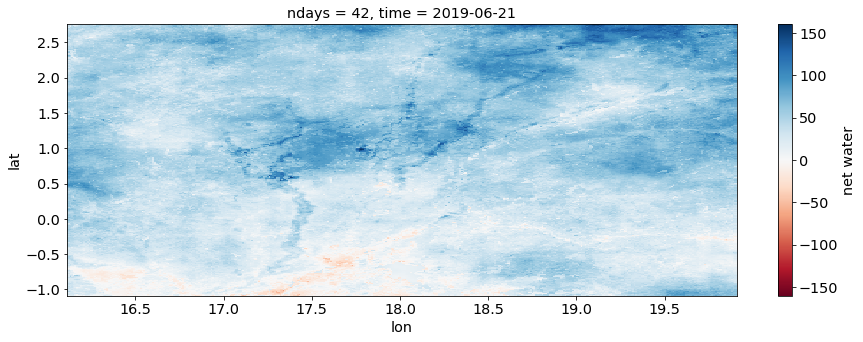

In [14]:
# test plot of the outputs
nw_accums['net water'][1][41][::5,::5].plot(cmap='RdBu')

In [15]:
# Saving to netcdf
nw_accums.to_netcdf(path = ALOS_OUT + 'nw_accums_new.nc')

### Calculating the new pixel wise correlations

### QUICKSTART 1
- reads in the nw_accums file and uses it to calculate the pixel-wise correlations between $\delta\gamma_0$ and nw accumulation between the subsequent image dates 


In [51]:
# the net water accumulations calculated between subsequent ALOS-2 image dates
nw_accums = xr.open_dataset(ALOS_OUT + '../ALOS_nc3/nw_accums_new.nc')

# swap lat order
# reversing the lat index (currently from high to low)
nw_accums = nw_accums.reindex(lat=nw_accums.lat[::-1])

In [ ]:
# selecting the nw_accums image for each date pair that corresponds with the highest number of days accumulation
# either 28 or 42, and creating a new single timeseries from this

new_array = []
for i in range(len(nw_accums['net water'])):
    # appending the max net water accumulation period (42 or 28 days)
    num = days_diff_final[i] - 1
    new_array.append(nw_accums['net water'][i][num])

delta_nw_max = xr.concat(new_array, dim = 'time')

In [ ]:
%%time
# pixel wise correlations - new version (old version from PW_corr_quickstart.ipynb is still good for ndays version)
da1 = HH_db_100m['db'][:14] # x
da2 = delta_nw_max   # y

# this step can be cutout if the netwater files are remade to the same grid exactly
da1 = da1.interp_like(da2)

corrs_da, covs_da, slopes_da, intercepts_da, pvals_da, stderrs_da = run_pixel_wise_correlations(da1,da2,'HH')